## Plots delays, throughputs, packet loss and path for all links

In [20]:
%matplotlib inline
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from datetime import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from datetime import datetime
import numpy as np
import pandas as pd

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
my_index = "network_weather_2-*"

my_query = {}

## Get the data from Elasticsearch, and store the record based on its type

In [34]:
query={
   "size": 0,
   "query": {
    "bool": {
      "should":[
         {"term": { "_type" : "packet_loss_rate"}},
         {"term": { "_type" : "throughput"}},
         {"term": { "_type" : "latency"}}
      ],
      "must": [
        {"term": { "srcProduction" : True }},
        {"term": { "destProduction" : True }}
      ],
      "filter" : {
        'range': {'timestamp': {'gte': '2016-07-01', 'lt': '2016-08-28'}}
      }
    }
   },
    "aggs" : {
        "timeBins" : {
            "date_histogram" : { "field" : "timestamp", "interval" : "week" },
       "aggs":{
      "src" : {
        "terms" : { "field" : "srcSite", "size": 1000 },
        "aggs" : {
          "dest" : {
            "terms" : {"field" : "destSite", "size": 1000},
            "aggs" : {
              "avgpl" : {
                "avg" :{ "field" : "packet_loss" }
              },
              "avgde" : {
                "avg" :{ "field" : "delay_mean" }
              },  
              "avgth" : {
                "avg" :{ "field" : "throughput" }
              }
          }
        }
      }
    }}
  } 
}        
}

res = es.search(index=my_index, body=query, request_timeout=120)

In [35]:
count = 0
PL=[];D=[];T=[]
# print (res)
for t in res['aggregations']['timeBins']['buckets']:
    for s in t['src']['buckets']:
        for d in s['dest']['buckets']:
#         print(d)
            if d['avgpl']['value']==None or d['avgpl']['value']>0.1: continue
            if d['avgde']['value']==None or d['avgde']['value']>200 or d['avgde']['value']<-5 : continue
            if d['avgth']['value']==None: continue
            
            PL.append(d['avgpl']['value'])
            D.append(d['avgde']['value'])
            T.append(d['avgth']['value']/1024./1024./1024.)
            count += 1
        #if count<2: print(d)
print(count)

16264


In [36]:
#for i in range(len(D)):
#    print(D[i],PL[i],T[i])

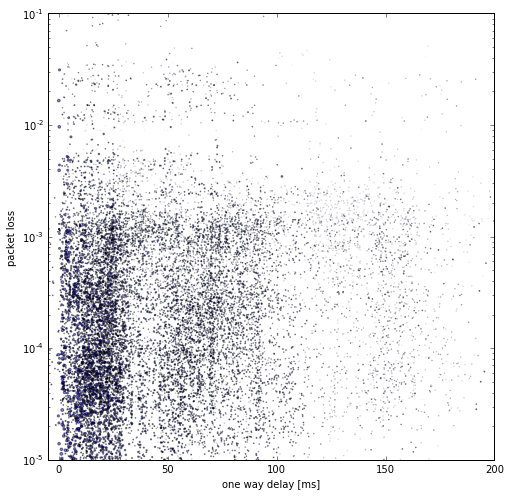

In [37]:
plt.figure(figsize=[8, 8])
plt.scatter( D, PL, s=T*10, alpha=0.5)
plt.xlabel('one way delay [ms]')
plt.ylabel('packet loss')
plt.ylim([0.00001,.1])
plt.xlim([-5,200])
plt.yscale("log")

# plt.savefig('Plots/CorrelationPlotsForLink_' + sS +'_'+ dS + '.png',dpi=200)
plt.show()

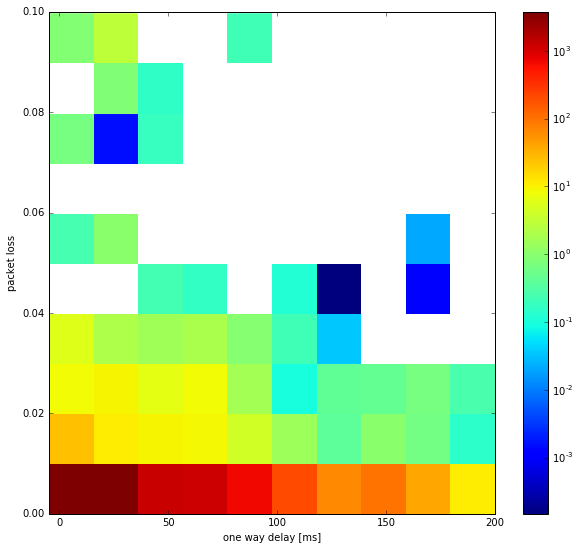

In [40]:
plt.figure(figsize=[10, 9])
plt.hist2d( D, PL, bins=[10,10], weights=T, norm=LogNorm())
plt.xlabel('one way delay [ms]')
plt.ylabel('packet loss')
plt.ylim([0.00001,.1])
plt.xlim([-5,200])
#plt.yscale("log")
plt.colorbar()
plt.savefig('Plots/CorrelationPlotsForAllLinks.png')
plt.show()